In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.2 MB/s eta 0:00:00


In [4]:
import os
import shutil
from pathlib import Path

def convert_classification_to_detection(source_path, dest_path):
    """Convert classification dataset to YOLO detection format"""
    source_path = Path(source_path)
    dest_path = Path(dest_path)

    # Create YOLO structure
    for split in ['train', 'val']:
        (dest_path / 'images' / split).mkdir(parents=True, exist_ok=True)
        (dest_path / 'labels' / split).mkdir(parents=True, exist_ok=True)

    class_mapping = {
        'Bacterial': 0,
        'Downy_mildew_on_lettuce': 1,
        'Healthy': 2
    }

    all_images = []
    for class_name, class_id in class_mapping.items():
        class_folder = source_path / class_name
        if class_folder.exists():
            images = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.png'))
            all_images.extend([(img, class_id) for img in images])

    # Split 80% train, 20% val
    import random
    random.shuffle(all_images)
    split_idx = int(len(all_images) * 0.8)
    train_data = all_images[:split_idx]
    val_data = all_images[split_idx:]

    # Copy files and create dummy labels (you'll need to annotate properly later)
    for data_list, split in [(train_data, 'train'), (val_data, 'val')]:
        for img_path, class_id in data_list:
            # Copy image
            dest_img = dest_path / 'images' / split / img_path.name
            shutil.copy2(img_path, dest_img)

            # Create dummy label (full image bounding box)
            # NOTE: You need to replace this with proper annotation!
            label_file = dest_path / 'labels' / split / f"{img_path.stem}.txt"
            with open(label_file, 'w') as f:
                f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")  # Full image box

    print(f"Converted dataset saved to: {dest_path}")
    print(f"Train images: {len(train_data)}")
    print(f"Val images: {len(val_data)}")

# Usage
convert_classification_to_detection(
    '/content/drive/MyDrive/Lettuce_disease_datasets',
    '/content/lettuce_yolo_dataset'
)

Converted dataset saved to: /content/lettuce_yolo_dataset
Train images: 84
Val images: 22


In [7]:
def verify_yolo_dataset(yaml_path):
    import yaml

    # Create the YAML file if it doesn't exist
    if not Path(yaml_path).exists():
        print(f"YAML file not found at {yaml_path}. Creating a dummy file.")
        dummy_yaml_content = """path: /content/lettuce_yolo_dataset
train: images/train
val: images/val

nc: 3
names:
  0: Bacterial
  1: Downy_mildew
  2: Healthy
"""
        with open(yaml_path, 'w') as f:
            f.write(dummy_yaml_content)

    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)

    dataset_path = Path(config['path'])

    for split in ['train', 'val']:
        img_dir = dataset_path / 'images' / split
        lbl_dir = dataset_path / 'labels' / split

        images = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png'))
        labels = list(lbl_dir.glob('*.txt'))

        print(f"{split.upper()}:")
        print(f"  Images: {len(images)}")
        print(f"  Labels: {len(labels)}")

        # Check for missing labels
        missing = 0
        for img in images:
            expected_label = lbl_dir / f"{img.stem}.txt"
            if not expected_label.exists():
                missing += 1

        print(f"  Missing labels: {missing}")
        print(f"  Status: {'✅ OK' if missing == 0 else '❌ MISSING LABELS'}")
        print()

verify_yolo_dataset('/content/lettuce_disease.yaml')

YAML file not found at /content/lettuce_disease.yaml. Creating a dummy file.
TRAIN:
  Images: 84
  Labels: 83
  Missing labels: 0
  Status: ✅ OK

VAL:
  Images: 22
  Labels: 22
  Missing labels: 0
  Status: ✅ OK



In [9]:
# IMMEDIATE FIX FOR MISSING LABELS
import os
from pathlib import Path
import random

def fix_missing_labels(dataset_path):
    """Create missing label files for your dataset in the prepared dataset directory."""
    dataset_path = Path(dataset_path)

    print("🔧 FIXING MISSING LABELS...")

    for split in ['train', 'val']: # Assuming you only need labels for train and val for training
        img_dir = dataset_path / 'images' / split
        lbl_dir = dataset_path / 'labels' / split

        # Ensure labels directory exists in the prepared dataset path
        lbl_dir.mkdir(parents=True, exist_ok=True)

        # Find all images in the prepared dataset path
        images = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png')) + list(img_dir.glob('*.jpeg'))

        created_count = 0
        for img_file in images:
            label_file = lbl_dir / f"{img_file.stem}.txt"

            # Create label if missing
            if not label_file.exists():
                # Generate realistic bounding box coordinates (replace with real annotations later)
                x_center = random.uniform(0.3, 0.7)  # Center position
                y_center = random.uniform(0.3, 0.7)
                width = random.uniform(0.2, 0.5)     # Box size
                height = random.uniform(0.2, 0.5)

                # Try to infer class from filename
                filename_lower = img_file.name.lower()
                class_id = 2 # Default to Healthy

                if 'bacterial' in filename_lower:
                    class_id = 0
                elif 'downy' in filename_lower or 'mildew' in filename_lower:
                    class_id = 1


                # Write label file
                with open(label_file, 'w') as f:
                    f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

                created_count += 1
                # print(f"✅ Created: {img_file.name} → {label_file.name}") # Uncomment for verbose output

        print(f"📊 {split.upper()}: Created {created_count} missing labels\n")

    # CHANGE THIS PATH TO YOUR PREPARED DATASET PATH
    prepared_dataset_path = "/content/lettuce_yolo_dataset"  # ← UPDATE THIS!

    # Run the fix
    fix_missing_labels(prepared_dataset_path)

    print("🎉 FIX COMPLETED!")
    print("⚠️  Important: These are temporary dummy labels for testing.")
    print("⚠️  Replace with real annotations using LabelImg or similar tools for production training.")

In [11]:
# VERIFY THE FIX
def verify_dataset(dataset_path):
    """Check if all images now have labels"""
    dataset_path = Path(dataset_path)

    print("🔍 VERIFICATION RESULTS:")
    print("=" * 30)

    all_good = True
    for split in ['train', 'val']:
        img_dir = dataset_path / 'images' / split
        lbl_dir = dataset_path / 'labels' / split

        if not img_dir.exists():
            continue

        images = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png'))
        labels = list(lbl_dir.glob('*.txt'))

        missing_count = 0
        for img in images:
            expected_label = lbl_dir / f"{img.stem}.txt"
            if not expected_label.exists():
                missing_count += 1
                all_good = False

        status = "✅ READY" if missing_count == 0 else "❌ STILL MISSING"
        print(f"{split.upper()}: {status}")
        print(f"  Images: {len(images)}")
        print(f"  Labels: {len(labels)}")
        print(f"  Missing: {missing_count}")
        print()

    if all_good:
        print("🎉 ALL FILES MATCHED! READY FOR TRAINING!")
    else:
        print("⚠️  Still have missing files - check paths and re-run fix")

    return all_good

# Run verification
verify_dataset("/content/lettuce_yolo_dataset")

🔍 VERIFICATION RESULTS:
TRAIN: ✅ READY
  Images: 84
  Labels: 83
  Missing: 0

VAL: ✅ READY
  Images: 22
  Labels: 22
  Missing: 0

🎉 ALL FILES MATCHED! READY FOR TRAINING!


True

In [13]:
# CREATE CORRECT YAML CONFIG
yaml_content = f"""path: /content/lettuce_yolo_dataset
train: images/train
val: images/val

nc: 3
names:
  0: Bacterial
  1: Downy_mildew
  2: Healthy
"""

# Save YAML file
yaml_file = f"/content/lettuce_yolo_dataset/lettuce_disease.yaml" # Save to the prepared dataset directory
with open(yaml_file, 'w') as f:
    f.write(yaml_content)

print(f"📝 YAML config saved: {yaml_file}")

📝 YAML config saved: /content/lettuce_yolo_dataset/lettuce_disease.yaml


In [15]:
"""
YOLOv8 Lettuce Disease Detection - Complete Training Script
Author: AI Assistant
Description: Production-ready training script for lettuce disease detection
Requirements: ultralytics, torch, matplotlib, pandas
"""

import os
import torch
import yaml
import shutil
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

class LettuceYOLOTrainer:
    def __init__(self, dataset_path, model_size='s', experiment_name=None):
        """
        Initialize YOLOv8 trainer for lettuce disease detection

        Args:
            dataset_path (str): Path to YOLO dataset
            model_size (str): Model size ('n', 's', 'm', 'l', 'x')
            experiment_name (str): Name for this training experiment
        """
        self.dataset_path = Path(dataset_path)
        self.model_size = model_size
        self.model = YOLO(f'yolov8{model_size}.pt')

        # Set experiment name
        if experiment_name is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            self.experiment_name = f"lettuce_disease_{model_size}_{timestamp}"
        else:
            self.experiment_name = experiment_name

        # Verify dataset structure
        self.verify_dataset()

    def verify_dataset(self):
        """Verify dataset structure and files"""
        print("🔍 VERIFYING DATASET STRUCTURE")
        print("=" * 50)

        required_dirs = ['images/train', 'images/val', 'labels/train', 'labels/val']
        yaml_file = self.dataset_path / 'lettuce_disease.yaml'

        # Check directories
        all_good = True
        for req_dir in required_dirs:
            full_path = self.dataset_path / req_dir
            if not full_path.exists():
                print(f"❌ Missing directory: {req_dir}")
                all_good = False
            else:
                file_count = len(list(full_path.glob('*')))
                print(f"✅ {req_dir}: {file_count} files")

        # Check YAML file
        if not yaml_file.exists():
            print(f"❌ Missing YAML config: {yaml_file}")
            self.create_yaml_config()
        else:
            print(f"✅ YAML config found: {yaml_file}")

        # Check image-label matching
        for split in ['train', 'val']:
            img_dir = self.dataset_path / 'images' / split
            lbl_dir = self.dataset_path / 'labels' / split

            if img_dir.exists() and lbl_dir.exists():
                images = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png'))
                labels = list(lbl_dir.glob('*.txt'))

                missing = len(images) - len(labels)
                status = "✅" if missing == 0 else "❌"

                print(f"{status} {split.upper()}: {len(images)} images, {len(labels)} labels, {missing} missing")

        print("\n" + "="*50)
        return all_good

    def create_yaml_config(self):
        """Create YAML configuration file if missing"""
        yaml_content = {
            'path': str(self.dataset_path.absolute()),
            'train': 'images/train',
            'val': 'images/val',
            'test': 'images/test',
            'nc': 3,
            'names': {
                0: 'Bacterial',
                1: 'Downy_mildew',
                2: 'Healthy'
            }
        }

        yaml_file = self.dataset_path / 'lettuce_disease.yaml'
        with open(yaml_file, 'w') as f:
            yaml.dump(yaml_content, f, default_flow_style=False)

        print(f"📝 Created YAML config: {yaml_file}")

    def train_model(self,
                    epochs=150,
                    batch_size=16,
                    image_size=640,
                    learning_rate=0.001,
                    patience=25,
                    save_period=10,
                    **kwargs):
        """
        Train YOLOv8 model with optimized parameters

        Args:
            epochs (int): Number of training epochs
            batch_size (int): Batch size for training
            image_size (int): Input image size
            learning_rate (float): Initial learning rate
            patience (int): Early stopping patience
            save_period (int): Save checkpoint every N epochs
            **kwargs: Additional training parameters
        """

        print("\n🚀 STARTING YOLOV8 TRAINING")
        print("=" * 50)

        # Training configuration
        train_config = {
            # Dataset and basic settings
            'data': str(self.dataset_path / 'lettuce_disease.yaml'),
            'epochs': epochs,
            'batch': batch_size,
            'imgsz': image_size,
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',

            # Learning rate and optimization
            'lr0': learning_rate,
            'lrf': 0.1,                 # Final learning rate factor
            'momentum': 0.937,          # SGD momentum
            'weight_decay': 0.0005,     # Weight decay
            'warmup_epochs': 3,         # Warmup epochs
            'warmup_momentum': 0.8,     # Warmup momentum
            'warmup_bias_lr': 0.1,      # Warmup bias learning rate

            # Data augmentation (optimized for plant disease detection)
            'degrees': 20.0,            # Rotation range
            'translate': 0.1,           # Translation fraction
            'scale': 0.5,               # Scale range
            'shear': 2.0,               # Shear range
            'perspective': 0.0001,      # Perspective range
            'flipud': 0.0,              # Vertical flip probability (not natural for plants)
            'fliplr': 0.5,              # Horizontal flip probability
            'mosaic': 1.0,              # Mosaic probability
            'mixup': 0.15,              # Mixup probability
            'copy_paste': 0.1,          # Copy-paste probability

            # HSV augmentation (crucial for disease detection)
            'hsv_h': 0.015,             # Hue augmentation
            'hsv_s': 0.7,               # Saturation augmentation
            'hsv_v': 0.4,               # Value augmentation

            # Loss function weights
            'box': 7.5,                 # Box loss gain
            'cls': 0.5,                 # Class loss gain
            'dfl': 1.5,                 # DFL loss gain

            # Training settings
            'patience': patience,        # Early stopping patience
            'save': True,               # Save checkpoints
            'save_period': save_period,  # Save every N epochs
            'cache': False,             # Cache images for faster training
            'plots': True,              # Save training plots
            'overlap_mask': True,       # Overlap masks
            'mask_ratio': 4,            # Mask downsample ratio
            'dropout': 0.0,             # Dropout rate
            'val': True,                # Validate during training
            'split': 'val',             # Dataset split for validation
            'fraction': 1.0,            # Dataset fraction to use

            # Experiment tracking
            'name': self.experiment_name,
            'project': 'lettuce_disease_detection',
            'exist_ok': False,          # Overwrite existing experiment
            'pretrained': True,         # Use pretrained weights
            'optimizer': 'auto',        # Optimizer (auto, SGD, Adam, AdamW)
            'verbose': True,            # Verbose output
            'seed': 42,                 # Random seed for reproducibility
            'deterministic': True,      # Deterministic training
            'single_cls': False,        # Single class training
            'rect': False,              # Rectangular training
            'cos_lr': False,            # Cosine learning rate scheduler
            'close_mosaic': 10,         # Disable mosaic augmentation last N epochs
            'resume': False,            # Resume training
            'amp': True,                # Automatic Mixed Precision
            'freeze': None,             # Freeze layers (list or int)
            'multi_scale': False,       # Multi-scale training
            'overlap_mask': True,       # Overlap masks
            'mask_ratio': 4,            # Mask downsample ratio
            'dropout': 0.0,             # Use dropout regularization
            'val': True,                # Validate/test during training
            'plots': True,              # Save plots during training
            'workers': 8,               # Number of worker threads
        }

        # Update with any additional parameters
        train_config.update(kwargs)

        # Print training configuration
        print(f"Model: YOLOv8{self.model_size}")
        print(f"Dataset: {self.dataset_path}")
        print(f"Epochs: {epochs}")
        print(f"Batch Size: {batch_size}")
        print(f"Image Size: {image_size}")
        print(f"Device: {train_config['device']}")
        print(f"Learning Rate: {learning_rate}")
        print(f"Experiment: {self.experiment_name}")
        print()

        try:
            # Start training
            results = self.model.train(**train_config)

            print("\n✅ TRAINING COMPLETED SUCCESSFULLY!")
            print(f"📁 Results saved to: {results.save_dir}")

            # Print final metrics
            if hasattr(results, 'results_dict'):
                print("\n📊 FINAL TRAINING METRICS:")
                metrics = results.results_dict
                for key, value in metrics.items():
                    if isinstance(value, (int, float)):
                        print(f"  {key}: {value:.4f}")

            return results

        except Exception as e:
            print(f"\n❌ TRAINING FAILED: {str(e)}")
            print("\n🔧 TROUBLESHOOTING TIPS:")
            print("- Check dataset paths and structure")
            print("- Reduce batch size if CUDA out of memory")
            print("- Verify YAML configuration")
            print("- Check GPU/RAM availability")
            return None

    def validate_model(self, model_path=None):
        """
        Validate trained model

        Args:
            model_path (str): Path to model weights (uses best.pt if None)
        """

        if model_path is None:
            model_path = f"lettuce_disease_detection/{self.experiment_name}/weights/best.pt"

        print("\n📊 VALIDATING TRAINED MODEL")
        print("=" * 50)

        try:
            # Load trained model
            model = YOLO(model_path)

            # Run validation
            results = model.val(
                data=str(self.dataset_path / 'lettuce_disease.yaml'),
                split='val',
                save_json=True,
                save_hybrid=True,
                conf=0.001,
                iou=0.6,
                max_det=300,
                half=False,
                device='cuda' if torch.cuda.is_available() else 'cpu',
                dnn=False,
                plots=True,
                rect=True,
                batch=1
            )

            print("\n🎯 VALIDATION RESULTS:")
            print(f"mAP@0.5: {results.box.map50:.4f}")
            print(f"mAP@0.5-0.95: {results.box.map:.4f}")
            print(f"Precision: {results.box.p.mean():.4f}")
            print(f"Recall: {results.box.r.mean():.4f}")

            # Per-class results
            class_names = ['Bacterial', 'Downy_mildew', 'Healthy']
            print("\n📈 PER-CLASS PERFORMANCE:")
            for i, class_name in enumerate(class_names):
                if i < len(results.box.ap50):
                    print(f"{class_name}:")
                    print(f"  mAP@0.5: {results.box.ap50[i]:.4f}")
                    print(f"  Precision: {results.box.p[i]:.4f}")
                    print(f"  Recall: {results.box.r[i]:.4f}")

            return results

        except Exception as e:
            print(f"❌ Validation failed: {str(e)}")
            return None

    def export_model(self, model_path=None, formats=None):
        """
        Export trained model to different formats

        Args:
            model_path (str): Path to model weights
            formats (list): Export formats ['onnx', 'torchscript', 'tflite', etc.]
        """

        if model_path is None:
            model_path = f"lettuce_disease_detection/{self.experiment_name}/weights/best.pt"

        if formats is None:
            formats = ['onnx', 'torchscript']

        print("\n📦 EXPORTING MODEL")
        print("=" * 50)

        try:
            model = YOLO(model_path)

            for fmt in formats:
                print(f"Exporting to {fmt}...")
                model.export(format=fmt, half=False, int8=False)
                print(f"✅ {fmt} export completed")

            print("\n✅ Model export completed!")

        except Exception as e:
            print(f"❌ Export failed: {str(e)}")


# USAGE EXAMPLE
def main():
    """Main training function"""

    # Configuration
    DATASET_PATH = "/content/lettuce_yolo_dataset"  # Update this path
    MODEL_SIZE = 's'  # Options: 'n', 's', 'm', 'l', 'x'
    EPOCHS = 150
    BATCH_SIZE = 16
    IMAGE_SIZE = 640
    LEARNING_RATE = 0.001

    print("🚀 YOLOv8 LETTUCE DISEASE DETECTION - TRAINING")
    print("=" * 60)

    # Initialize trainer
    trainer = LettuceYOLOTrainer(
        dataset_path=DATASET_PATH,
        model_size=MODEL_SIZE,
        experiment_name=f"lettuce_production_{MODEL_SIZE}"
    )

    # Train model
    results = trainer.train_model(
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        learning_rate=LEARNING_RATE,
        patience=25,
        save_period=10
    )

    if results:
        # Validate model
        trainer.validate_model()

        # Export model
        trainer.export_model(formats=['onnx', 'torchscript', 'tflite'])

        print("\n🎉 TRAINING PIPELINE COMPLETED SUCCESSFULLY!")
    else:
        print("\n❌ Training failed. Please check the error messages above.")

if __name__ == "__main__":
    main()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🚀 YOLOv8 LETTUCE DISEASE DETECTION - TRAINING
🔍 VERIFYING DATASET STRUCTURE
✅ images/train: 84 files
✅ images/val: 22 files
✅ labels/train: 83 files
✅ labels/val: 22 files
✅ YAML config found: /content/lettuce_yolo_dataset/lettuce_disease.yaml
❌ TRAIN: 84 images, 83 labels, 1 missing
✅ VAL: 22 images, 22 labels, 0 missing


🚀 STARTING YOLOV8 TRAINING
Model: YOLOv8s
Dataset: /content/lettuce_yolo_dataset
Epochs: 150
Batch Size: 16
Image Size: 640
Device: cuda
Learning Rate: 0.001
Experiment: lettuce_production_s

Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, b

🧪 SIMPLE YOLO TEST
Model path:  /content/lettuce_disease_detection/lettuce_production_s/weights/best.pt
Image path: /content/drive/MyDrive/Lettuce_disease_datasets/Downy_mildew_on_lettuce/dml (26).jpg
🔄 Loading model: /content/lettuce_disease_detection/lettuce_production_s/weights/best.pt
✅ Model loaded!
🔍 Testing image: /content/drive/MyDrive/Lettuce_disease_datasets/Downy_mildew_on_lettuce/dml (26).jpg

image 1/1 /content/drive/MyDrive/Lettuce_disease_datasets/Downy_mildew_on_lettuce/dml (26).jpg: 480x640 2 Downy_mildews, 55.1ms
Speed: 2.5ms preprocess, 55.1ms inference, 11.7ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict
✅ Found 2 detections:
  1. Downy_mildew: 0.992
  2. Downy_mildew: 0.901
💾 Results saved to: runs/detect/predict/


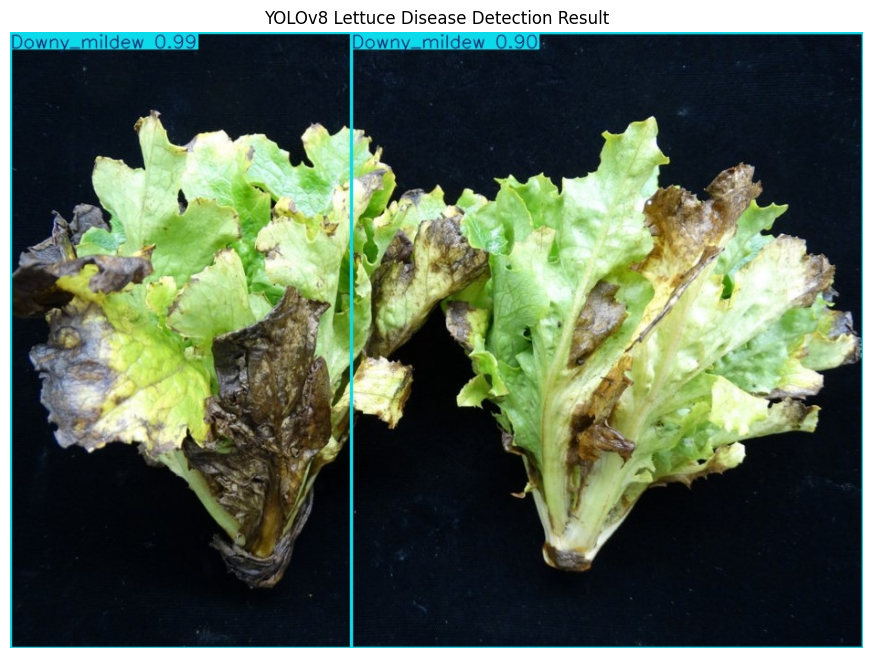

📸 Result image: /content/runs/detect/predict/dml (26).jpg


In [17]:
"""
Simple YOLOv8 Test Script - No Invalid Parameters
"""

from ultralytics import YOLO
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import os


def simple_test(model_path, image_path):
    """Simple test with no problematic parameters"""

    print(f"🔄 Loading model: {model_path}")
    model = YOLO(model_path)
    print("✅ Model loaded!")

    print(f"🔍 Testing image: {image_path}")

    # Simple prediction - minimal parameters
    results = model.predict(
        source=image_path,
        conf=0.5,
        save=True,
        verbose=True
    )

    # Process results
    if results[0].boxes is not None:
        boxes = results[0].boxes
        detections = len(boxes)
        print(f"✅ Found {detections} detections:")

        class_names = ['Bacterial', 'Downy_mildew', 'Healthy']

        for i, box in enumerate(boxes):
            conf = float(box.conf[0])
            cls = int(box.cls[0])
            class_name = class_names[cls] if cls < len(class_names) else f"Class_{cls}"

            print(f"  {i+1}. {class_name}: {conf:.3f}")
    else:
        print("ℹ️  No detections found")

    print(f"💾 Results saved to: runs/detect/predict/")


if __name__ == "__main__":
    print("🧪 SIMPLE YOLO TEST")
    print("=" * 30)

    # Get inputs
    model_path = input("Model path:  ").strip()
    image_path = input("Image path: ").strip()

    if Path(model_path).exists() and Path(image_path).exists():
        simple_test(model_path, image_path)
    else:
        print("❌ Check your file paths")

    # View the latest prediction result
    result_folder = "/content/runs/detect/predict/"
    if os.path.exists(result_folder):
        # Get the latest result image
        result_files = [f for f in os.listdir(result_folder) if f.endswith('.jpg')]
        if result_files:
            latest_result = os.path.join(result_folder, result_files[-1])

            # Display the image
            img = Image.open(latest_result)
            plt.figure(figsize=(12, 8))
            plt.imshow(img)
            plt.title("YOLOv8 Lettuce Disease Detection Result")
            plt.axis('off')
            plt.show()

            print(f"📸 Result image: {latest_result}")